#### RESNET50 Transfer Learning Implementation on the MNIST-HAM10000 Dataset 
- We will utilize the pre-trained ResNet50 CNN Model in order to carry out diagnosis on the image data exclusively.
- The ResNet50 implementation will yield a more accurate model but will be heavy.

In [13]:
#Import Libraries
import tensorflow as tf 
import keras as K 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import os

##### Carry out preliminary data analysis
- Plot distribution of categories in metadata.
- Print metadata information.

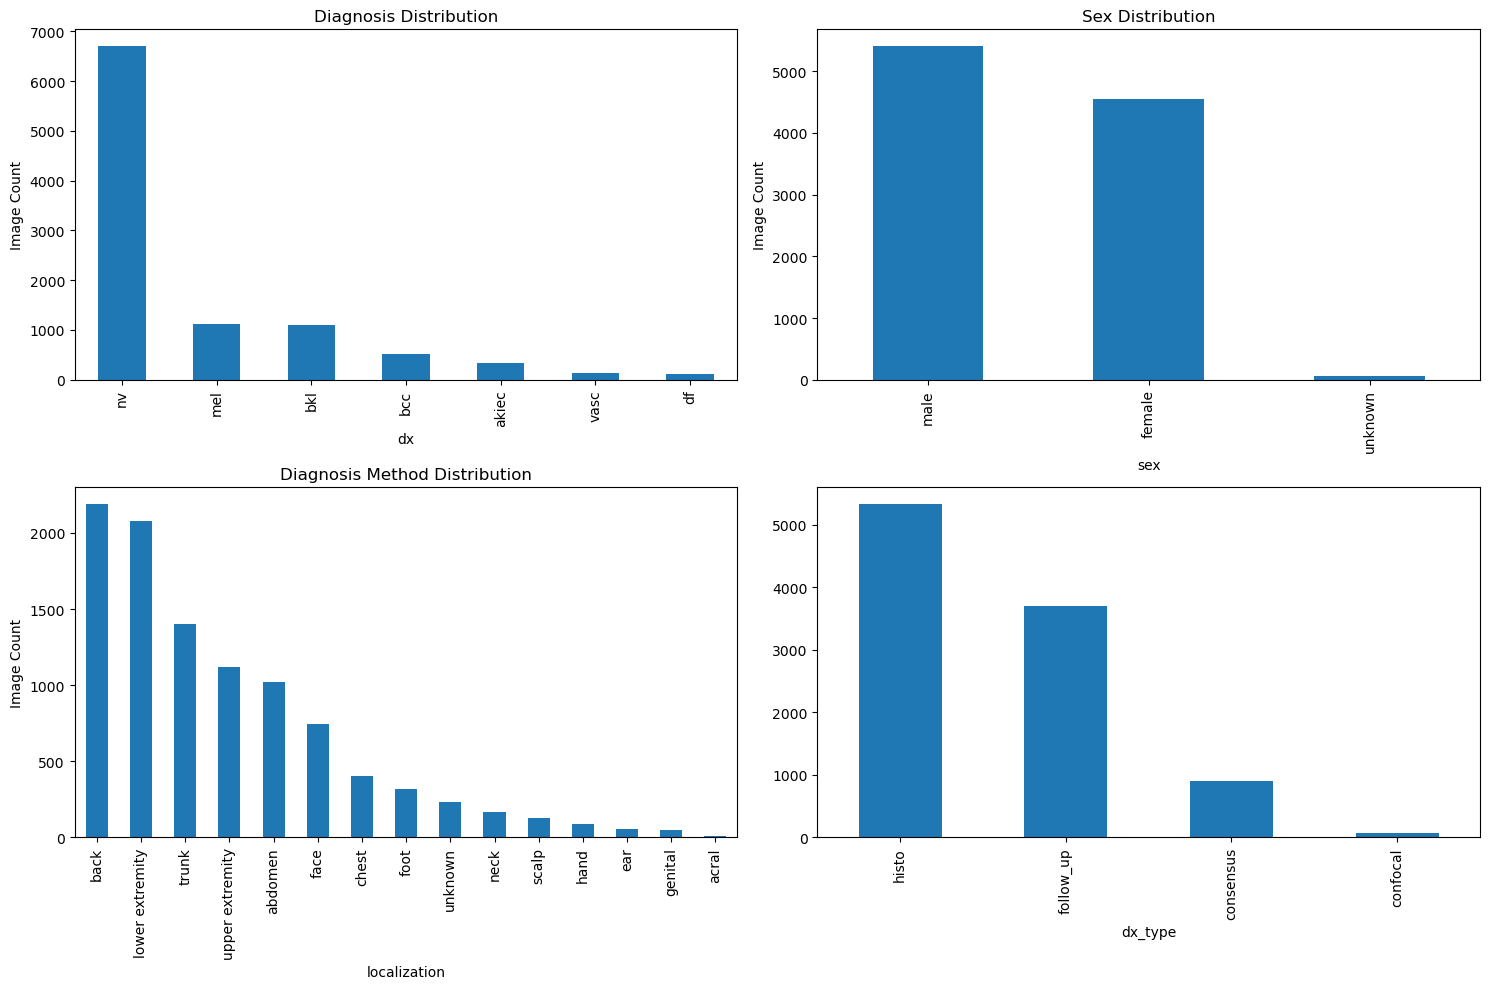

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [14]:
meta_data = pd.read_csv('data/HAM10000_metadata.csv')
fig = plt.figure(figsize=(15, 10))

#Diagnosis Distribution
ax1 = fig.add_subplot(221)
meta_data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Diagnosis Distribution')
ax1.set_ylabel('Image Count')

#Sex Distribution
ax2 = fig.add_subplot(222)
meta_data['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Sex Distribution')
ax2.set_ylabel('Image Count')

#Localization Distribution 
ax3 = fig.add_subplot(223)
meta_data['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Localization Distribution')
ax3.set_ylabel('Image Count')

#Diagnosis Method Distribution 
ax4 = fig.add_subplot(224)
meta_data['dx_type'].value_counts().plot(kind='bar', ax=ax4)
ax3.set_title('Diagnosis Method Distribution')
ax3.set_ylabel('Image Count')

plt.tight_layout()
plt.show()

#Info
print(meta_data.info())

##### Set up Hyper-Parameters

In [15]:
image_width = 224
image_height = 224
batch_size = 32
test_examples = 5021
validation_examples = 5047
train_examples = 32961

##### Initialize Model
- ResNet50 Pretrained

In [16]:
#Empty Model
resnet_model = K.models.Sequential()

#Pretrained Model
pretrained_model = K.applications.ResNet50(
    include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg', 
    classes=7,
    weights='imagenet'
)

#Set Pretrained Model weights to untrainable
# for layer in pretrained_model.layers:
#     layer.trainable = False

#Amalgamate our final model
resnet_model.add(pretrained_model)
resnet_model.add(K.layers.Flatten())
resnet_model.add(K.layers.Dense(512, activation='relu'))
resnet_model.add(K.layers.Dense(196, activation='relu'))
resnet_model.add(K.layers.Dense(7, activation='softmax'))

In [17]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dense_4 (Dense)             (None, 196)               100548    
                                                                 
 dense_5 (Dense)             (None, 7)                 1379      
                                                                 
Total params: 24738727 (94.37 MB)
Trainable params: 24685607 (94.17 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [18]:
resnet_model.save('resnet50_19JAN')

INFO:tensorflow:Assets written to: resnet50_19JAN/assets


INFO:tensorflow:Assets written to: resnet50_19JAN/assets


##### Initialize Data Generators and Data Loaders

In [19]:
#Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [20]:
#Instantiate Data Generators into loaders
train_gen = train_datagen.flow_from_directory(
    "data/reorganized_train",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
test_gen = test_datagen.flow_from_directory(
    "data/reorganized_test",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
validation_gen = validation_datagen.flow_from_directory(
    "data/reorganized_validation",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 32961 images belonging to 7 classes.
Found 5021 images belonging to 7 classes.
Found 5047 images belonging to 7 classes.


In [21]:
#Load model
resnet_model = K.models.load_model('resnet50_19JAN')

In [22]:
resnet_model.compile(
    optimizer=K.optimizers.Adam(learning_rate=3e-4),
    loss = [K.losses.CategoricalCrossentropy(from_logits=False)],
    metrics = ['accuracy']
    )

In [23]:
# checkpoint_path = "training_1_resnet/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

##### Train the Model according to Hyper-Parameters.

In [24]:
histroy = resnet_model.fit_generator(
    train_gen,
    epochs=10,
    steps_per_epoch=train_examples//batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples//batch_size,
)
resnet_model.save('resnet50_19JAN')

/tmp/ipykernel_8940/3324947562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  histroy = resnet_model.fit_generator(


Epoch 1/10
1030/1030 [==============================] - 355s 329ms/step - loss: 0.5579 - accuracy: 0.7988 - val_loss: 3.2858 - val_accuracy: 0.3230
Epoch 2/10
1030/1030 [==============================] - 256s 248ms/step - loss: 0.3071 - accuracy: 0.8896 - val_loss: 0.9859 - val_accuracy: 0.6921
Epoch 3/10
1030/1030 [==============================] - 276s 268ms/step - loss: 0.2275 - accuracy: 0.9193 - val_loss: 3.5734 - val_accuracy: 0.3869
Epoch 4/10
1030/1030 [==============================] - 339s 330ms/step - loss: 0.1912 - accuracy: 0.9312 - val_loss: 3.6677 - val_accuracy: 0.4873
Epoch 5/10
1030/1030 [==============================] - 357s 347ms/step - loss: 0.1553 - accuracy: 0.9438 - val_loss: 4.9484 - val_accuracy: 0.3414
Epoch 6/10
1030/1030 [==============================] - 292s 283ms/step - loss: 0.1462 - accuracy: 0.9470 - val_loss: 2.4871 - val_accuracy: 0.5100
Epoch 7/10
1030/1030 [==============================] - 317s 308ms/step - loss: 0.1264 - accuracy: 0.9547 - val_

INFO:tensorflow:Assets written to: resnet50_19JAN/assets


In [25]:
resnet_model.evaluate(validation_gen)
resnet_model.evaluate(test_gen)

157/157 [==============================] - 19s 122ms/step - loss: 2.3377 - accuracy: 0.5764


[2.3376874923706055, 0.5763791799545288]

In [26]:
resnet_model.save("Prototyped_Models/resnet-50_standard.h5", save_format='h5')

/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Convert to tflite

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model = converter.convert()
open("Prototyped_Models/converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvww08vtl/assets


INFO:tensorflow:Assets written to: /tmp/tmpvww08vtl/assets
2024-01-19 22:44:02.131926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-19 22:44:02.131963: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-19 22:44:02.132372: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvww08vtl
2024-01-19 22:44:02.166873: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-19 22:44:02.166912: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvww08vtl
2024-01-19 22:44:02.232248: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-19 22:44:02.273739: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-19 22:44:03.761586: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

98584844

[0. 0. 0. 0. 1. 0. 0.]


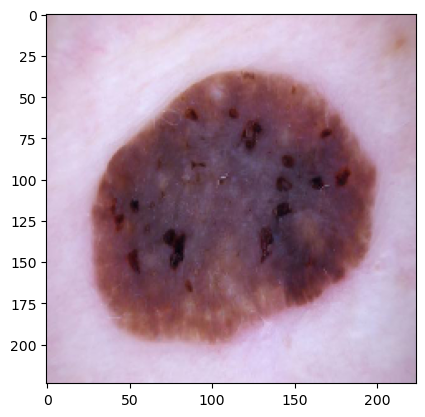

In [28]:
image = test_gen.next()[0][0]
plt.imshow(image)
print(test_gen.next()[1][0])

In [29]:
prediction = resnet_model(image.reshape(1, 224, 224, 3))
print(prediction)

tf.Tensor(
[[2.1098391e-10 5.9110792e-09 9.9936932e-01 7.3870590e-11 2.0134293e-07
  6.3044671e-04 5.3063638e-09]], shape=(1, 7), dtype=float32)
